# BertTopic

In this tutorial we will be using a package called BERTopic. Which utilize BERT for topic modelling. Those of you who are interested to know how it works are encouraged to read the following [link](https://maartengr.github.io/BERTopic/tutorial/algorithm/algorithm.html) 




# Installing BERTopic

We start by installing BERTopic from PyPi:

In [1]:
%%capture
!pip install -q bertopic

In [3]:
import logging

logger = logging.getLogger('BERTopic')
logger.addHandler(logging.NullHandler())
logger.propagate = False

In [4]:
import warnings
warnings.filterwarnings("ignore")

## Restart the Notebook
After installing BERTopic, some packages that were already loaded were updated and in order to correctly use them, we should now restart the notebook.

From the Menu:

Runtime → Restart Runtime

# **Data**
For this tutorial, we will be needing to extract all Trump's Tweet from his @realDonalTrump account. We will be removing all retweet and focus on his original tweets. 


In [12]:
import re
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

In [5]:
# Load data
trump = pd.read_csv('https://drive.google.com/uc?export=download&id=1xRKHaP-QwACMydlDnyFPEaFdtskJuBa6')

# Filter
trump.text = trump.apply(lambda row: re.sub(r"http\S+", "", row.text).lower(), 1)
trump.text = trump.apply(lambda row: " ".join(filter(lambda x:x[0]!="@", row.text.split())), 1)
trump.text = trump.apply(lambda row: " ".join(re.sub("[^a-zA-Z]+", " ", row.text).split()), 1)
trump = trump.loc[(trump.isRetweet == "f") & (trump.text != ""), :]
timestamps = trump.date.to_list()
tweets = trump.text.to_list()

In [2]:
tweets[0]

'republicans and democrats have both created our economic problems'

## Basic Topic Model


In [3]:
from bertopic import BERTopic
topic_model = BERTopic(nr_topics=100 ,verbose=True)
topics, _ = topic_model.fit_transform(tweets)

2021-06-13 13:12:58,644 - BERTopic - Transformed documents to Embeddings


2021-06-13 13:13:44,179 - BERTopic - Reduced dimensionality with UMAP
2021-06-13 13:13:47,665 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-06-13 13:14:15,986 - BERTopic - Reduced number of topics from 565 to 101


The topics variable  is the assignment of the tweets to the corresponding 100 clusters please note that tweets with a value of -1 are unassigned to any cluster.

In [4]:
print(topics[:10])
print(len(tweets))
print(len(topics))

[-1, -1, 27, 31, -1, 5, -1, 42, 54, 71]
45355
45355


We can then extract most frequent topics:

In [5]:
freq = topic_model.get_topic_info()
freq.head(10)

Topic  Count                                       Name
0     -1  17339                -1_donald_who_president_his
1      0   1013      0_border_mexico_immigration_democrats
2      1    809             1_golf_scotland_club_turnberry
3      2    579              2_china_chinese_tariffs_trade
4      3    536         3_luck_congratulations_win_winning
5      4    528                    4_she_nancy_her_melania
6      5    498               5_bernie_sanders_america_guy
7      6    483  6_poll_omarosa_makeamericagreatagain_team
8      7    467                 7_yes_wow_conference_white
9      8    461        8_thank_winery_charlottesville_wine

-1 refers to all outliers and should typically be ignored. Next, let's take a look at a frequent topic that were generated:

In [6]:
topic_nr = freq.iloc[3]["Topic"]  # We select a frequent topic
topic_model.get_topic(topic_nr)   # You can select a topic number as shown above

[('china', 0.0886908609868086),
 ('chinese', 0.021902675552426126),
 ('tariffs', 0.01931708656428286),
 ('trade', 0.016122671043470756),
 ('dollars', 0.011043220561517535),
 ('billion', 0.009568273231762755),
 ('xi', 0.00823535409752166),
 ('countries', 0.007168286004807736),
 ('goods', 0.006151201936971982),
 ('usa', 0.005767129445474656)]

We can visualize the basic topics that were created with the Intertopic Distance Map. 

In [7]:
fig = topic_model.visualize_topics()
fig



# Silhouette Score

We will now move to your part, in which you will need to implement Silhouette score. A way to evaluate the quality of the clusters.

(source: wikipedia) The Silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters. 

The silhouette can be calculated with any distance metric, such as the Euclidean distance or the Manhattan distance. 

The score can be calculated using the following:





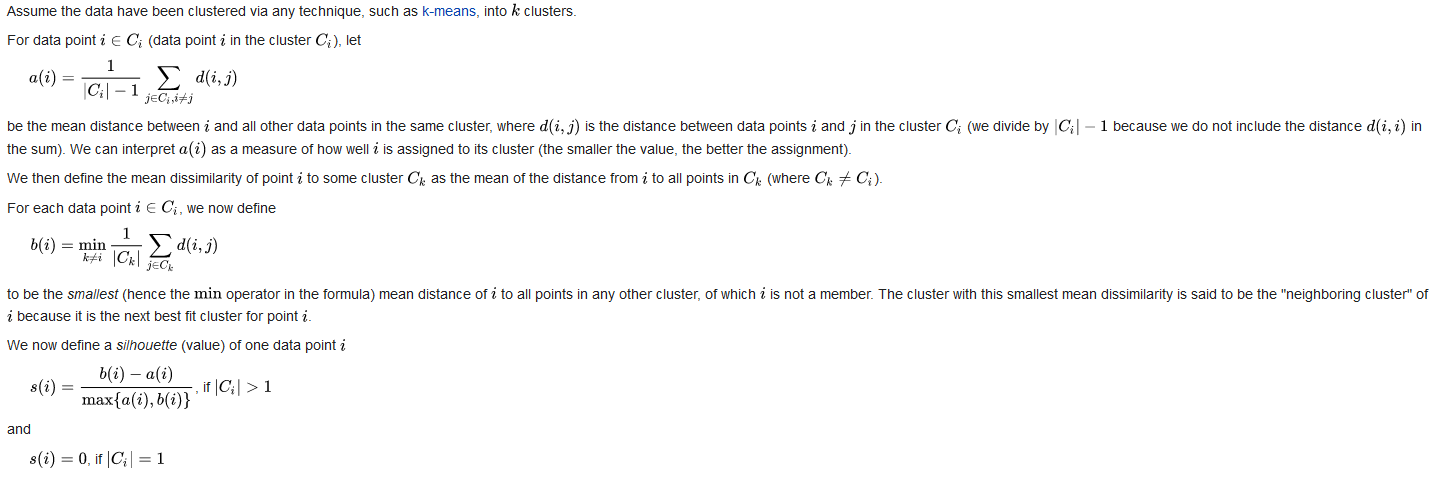

After calculating the score for each data point we can derive the score for the entire dataset by simply taking the mean.

# EX 1

Implement the score (for the entire dataset). Then claculate the score  coresponding to 5 instances of the topic modelling, each time calculated with a different number of topics  (nr_topics parameter in fit_transform) from the following values (50,100,150,250,500)


**Note thay you need to decide a few things on your own, e.g. which distance to use?**

## Implement silhouette score

In [ ]:
import scipy.spatial.distance as dist
import numpy as np

# return silhouette score for each sample using cosine distance
def silhouette_samples(X, clusters, metric='euclidean'):
    distances = dist.squareform(dist.pdist(X, metric=metric))
    X = np.array(X)
    clusters = np.array(clusters)
    cluster_nums = set(clusters)
    silhouettes = []
    
    for idx in range(len(X)):
        cluster = clusters[idx]
        point = X[idx]
        
        # find mean inter-cluster distance
        same_cluster_points_mask = (clusters==cluster)
        same_cluster_points_mask[idx] = False # remove the current point from the mask
        distances_to_same_cluster_points = distances[same_cluster_points_mask, idx]
        if len(distances_to_same_cluster_points) > 0:
            mean_inter_cluster_dist = distances_to_same_cluster_points.mean()
        else:
            silhouettes.append(0) # if the current cluster only has one point, silhouette score for this point is defined as 0
            continue # no need to calculate extra-cluster distances as we already know the silhouette score for that point

        # find mean extra-cluster distance with each other cluster and take the minimal one
        extra_cluster_distances = []
        for other_cluster in cluster_nums - set([cluster]):
            other_cluster_points_mask = (clusters==other_cluster)
            distances_to_other_cluster_points = distances[other_cluster_points_mask, idx]
            mean_extra_cluster_dist = distances_to_other_cluster_points.mean()
            extra_cluster_distances.append(mean_extra_cluster_dist)
        min_mean_extra_cluster_dist = min(extra_cluster_distances)
        
        # calculate & save silhouette score
        score = (min_mean_extra_cluster_dist - mean_inter_cluster_dist) / max(min_mean_extra_cluster_dist, mean_inter_cluster_dist)
        silhouettes.append(score)
            
    return np.array(silhouettes)

In [ ]:
# calculate mean silhouette score for all samples
def silhouette_score(X, clusters, metric='euclidean'):
    return silhouette_samples(X, clusters, metric).mean()

## Apply silhouette score on BERTopic

In [8]:
embeddings=topic_model._extract_embeddings(tweets) # extract the embeddigns - we need them in order to calculate distances between tweets
embeddings = topic_model._reduce_dimensionality(embeddings)
embeddings = MinMaxScaler().fit_transform(embeddings)
# we added dimension reductionality and min-max scaler like it's in the source of bertopic
# https://github.com/MaartenGr/BERTopic/blob/687d84612a62c5eeddcc089a4e29cbb4710ba23e/bertopic/_bertopic.py#L279
# https://github.com/MaartenGr/BERTopic/blob/687d84612a62c5eeddcc089a4e29cbb4710ba23e/bertopic/plotting/_topics.py#L62

2021-06-13 13:15:06,264 - BERTopic - Reduced dimensionality with UMAP


In [9]:
# before computing the score, let's exclude tweets that didn't get assigned to a topic
assigned_tweets_mask = np.array(topics)>-1

# extract only clustered tweets and their topics
clustered_tweet_embeddings = embeddings[assigned_tweets_mask,:] 
clustered_tweet_topics = np.array(topics)[assigned_tweets_mask]

In [10]:
# calculate mean silhouette score for all clustered tweets using euclidean distance metric
mean_score = silhouette_score(clustered_tweet_embeddings, clustered_tweet_topics, metric='euclidean') 
print(f'Mean silhouette_score for the entire dataset {mean_score:0.3f}')

Mean silhouette_score for the entire dataset -0.032


In [11]:
# calculate mean silhouette score for all clustered tweets using cosine distance metric (might be more approproate due to large dimentionality)
mean_score = silhouette_score(clustered_tweet_embeddings, clustered_tweet_topics, metric='cosine') 
print(f'Mean silhouette_score for the entire dataset {mean_score:0.3f}')

Mean silhouette_score for the entire dataset -0.251


We can see that the mean silhouette score we get is close to 0, which means that out method is probably generating overlapping clusters. 

It looks that way in intertopic distance map as well.


In [12]:
# now, let's calculate average score per each cluster
all_scores = silhouette_samples(clustered_tweet_embeddings, clustered_tweet_topics, metric='cosine') 
scores_per_cluster = pd.Series(data=all_scores, index=clustered_tweet_topics)
scores_per_cluster = scores_per_cluster.groupby(level=0).mean()

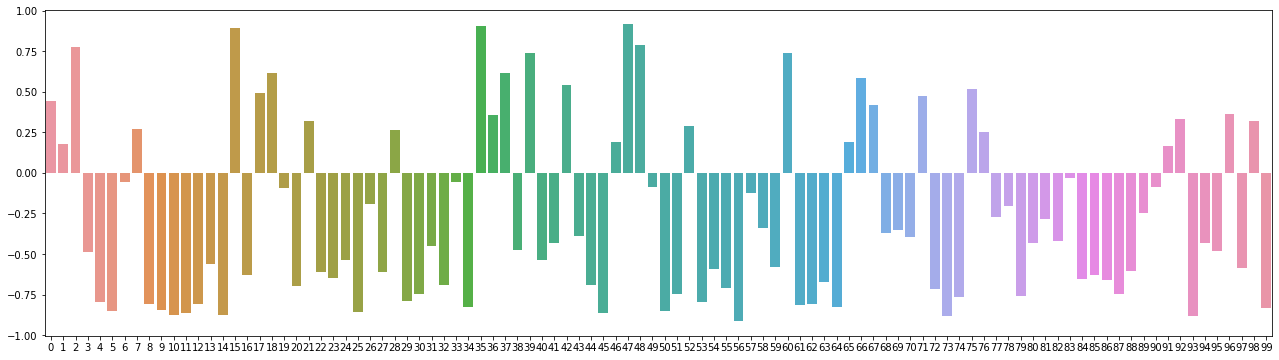

In [14]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(22,6))
sns.barplot(y=scores_per_cluster.values, x=scores_per_cluster.index);

We can see that most the scores are close to 0, but we do have a couple of nice clusters with score exceeding 0.4

## Calculate silhouette scores for various topic amounts

In [22]:
def calc_mean_silhouette(num_topics, use_dimension_reduction=False, metric='cosine'):
    # train the model
    topic_model = BERTopic(nr_topics=num_topics ,verbose=True)
    topics, _ = topic_model.fit_transform(tweets)
    
    # extract only clustered tweets and their topics
    embeddings = topic_model._extract_embeddings(tweets)
    if use_dimension_reduction:
      embeddings = topic_model._reduce_dimensionality(embeddings)
      embeddings = MinMaxScaler().fit_transform(embeddings)
    assigned_tweets_mask = np.array(topics)>-1
    clustered_tweet_embeddings = embeddings[assigned_tweets_mask,:] 
    clustered_tweet_topics = np.array(topics)[assigned_tweets_mask]

    # return mean silhouette score for all clustered tweets using cosine distance metric
    return silhouette_score(clustered_tweet_embeddings, clustered_tweet_topics, metric=metric) 

In [23]:
# calculate the mean score for each number of topics and save the results
final_mean_scores = {}
for num_topics in [50,100,150,250,500]:
    final_mean_scores[num_topics] = calc_mean_silhouette(num_topics)

final_mean_scores

2021-06-13 13:51:59,971 - BERTopic - Transformed documents to Embeddings


2021-06-13 13:52:26,609 - BERTopic - Reduced dimensionality with UMAP
2021-06-13 13:52:29,971 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-06-13 13:52:57,482 - BERTopic - Reduced number of topics from 575 to 51


2021-06-13 13:53:35,586 - BERTopic - Transformed documents to Embeddings


2021-06-13 13:54:00,036 - BERTopic - Reduced dimensionality with UMAP
2021-06-13 13:54:02,395 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-06-13 13:54:31,328 - BERTopic - Reduced number of topics from 568 to 101


2021-06-13 13:55:09,448 - BERTopic - Transformed documents to Embeddings


2021-06-13 13:55:34,586 - BERTopic - Reduced dimensionality with UMAP
2021-06-13 13:55:36,976 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-06-13 13:56:06,135 - BERTopic - Reduced number of topics from 559 to 151


2021-06-13 13:56:44,948 - BERTopic - Transformed documents to Embeddings


2021-06-13 13:57:12,378 - BERTopic - Reduced dimensionality with UMAP
2021-06-13 13:57:14,806 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-06-13 13:57:46,489 - BERTopic - Reduced number of topics from 559 to 251


2021-06-13 13:58:24,629 - BERTopic - Transformed documents to Embeddings


2021-06-13 13:58:50,795 - BERTopic - Reduced dimensionality with UMAP
2021-06-13 13:58:53,176 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-06-13 13:59:31,229 - BERTopic - Reduced number of topics from 572 to 501


{50: 0.016316697,
 100: 0.013043319,
 150: 0.032599416,
 250: 0.05948509,
 500: 0.07021556}

In [16]:
# calculate the mean score for each number of topics and save the results
final_mean_scores = {}
for num_topics in [50,100,150,250,500]:
    final_mean_scores[num_topics] = calc_mean_silhouette(num_topics, use_dimension_reduction=True)

final_mean_scores

2021-06-13 13:15:43,395 - BERTopic - Transformed documents to Embeddings


2021-06-13 13:16:08,116 - BERTopic - Reduced dimensionality with UMAP
2021-06-13 13:16:10,525 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-06-13 13:16:37,453 - BERTopic - Reduced number of topics from 560 to 51
2021-06-13 13:17:18,643 - BERTopic - Reduced dimensionality with UMAP


2021-06-13 13:17:39,026 - BERTopic - Transformed documents to Embeddings


2021-06-13 13:18:05,847 - BERTopic - Reduced dimensionality with UMAP
2021-06-13 13:18:08,263 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-06-13 13:18:36,712 - BERTopic - Reduced number of topics from 567 to 101
2021-06-13 13:19:15,829 - BERTopic - Reduced dimensionality with UMAP


2021-06-13 13:19:36,874 - BERTopic - Transformed documents to Embeddings


2021-06-13 13:20:01,536 - BERTopic - Reduced dimensionality with UMAP
2021-06-13 13:20:03,965 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-06-13 13:20:34,737 - BERTopic - Reduced number of topics from 580 to 151
2021-06-13 13:21:14,270 - BERTopic - Reduced dimensionality with UMAP


2021-06-13 13:21:34,396 - BERTopic - Transformed documents to Embeddings


2021-06-13 13:22:01,642 - BERTopic - Reduced dimensionality with UMAP
2021-06-13 13:22:03,958 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-06-13 13:22:35,346 - BERTopic - Reduced number of topics from 551 to 251
2021-06-13 13:23:17,143 - BERTopic - Reduced dimensionality with UMAP


2021-06-13 13:23:37,819 - BERTopic - Transformed documents to Embeddings


2021-06-13 13:24:04,582 - BERTopic - Reduced dimensionality with UMAP
2021-06-13 13:24:06,925 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-06-13 13:24:45,320 - BERTopic - Reduced number of topics from 583 to 501
2021-06-13 13:25:24,719 - BERTopic - Reduced dimensionality with UMAP


{50: -0.23744695,
 100: -0.22064978,
 150: -0.24920507,
 250: -0.19719778,
 500: -0.23478945}

In [20]:
# calculate the mean score for each number of topics and save the results
final_mean_scores = {}
for num_topics in [50,100,150,250,500]:
    final_mean_scores[num_topics] = calc_mean_silhouette(num_topics, use_dimension_reduction=True, metric='mahalanobis')

final_mean_scores

2021-06-13 13:26:59,331 - BERTopic - Transformed documents to Embeddings


2021-06-13 13:27:25,590 - BERTopic - Reduced dimensionality with UMAP
2021-06-13 13:27:27,967 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-06-13 13:27:54,908 - BERTopic - Reduced number of topics from 559 to 51
2021-06-13 13:28:36,665 - BERTopic - Reduced dimensionality with UMAP


2021-06-13 13:29:13,417 - BERTopic - Transformed documents to Embeddings


2021-06-13 13:29:40,687 - BERTopic - Reduced dimensionality with UMAP
2021-06-13 13:29:43,089 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-06-13 13:30:12,539 - BERTopic - Reduced number of topics from 587 to 101
2021-06-13 13:30:54,073 - BERTopic - Reduced dimensionality with UMAP


2021-06-13 13:31:30,201 - BERTopic - Transformed documents to Embeddings


2021-06-13 13:31:55,903 - BERTopic - Reduced dimensionality with UMAP
2021-06-13 13:31:58,301 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-06-13 13:32:28,566 - BERTopic - Reduced number of topics from 579 to 151
2021-06-13 13:33:09,831 - BERTopic - Reduced dimensionality with UMAP


2021-06-13 13:33:47,761 - BERTopic - Transformed documents to Embeddings


2021-06-13 13:34:11,928 - BERTopic - Reduced dimensionality with UMAP
2021-06-13 13:34:14,317 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-06-13 13:34:46,833 - BERTopic - Reduced number of topics from 579 to 251
2021-06-13 13:35:28,741 - BERTopic - Reduced dimensionality with UMAP


2021-06-13 13:36:06,647 - BERTopic - Transformed documents to Embeddings


2021-06-13 13:36:32,166 - BERTopic - Reduced dimensionality with UMAP
2021-06-13 13:36:34,643 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-06-13 13:37:12,032 - BERTopic - Reduced number of topics from 567 to 501
2021-06-13 13:37:51,629 - BERTopic - Reduced dimensionality with UMAP


{50: -0.033278432094027546,
 100: -0.007713432918250781,
 150: 0.02066580637488284,
 250: 0.094931992947357,
 500: 0.19380102057603762}

The higher then number of clusters/topics, the better is silhouette score. It's reasonable, because if we have less tweets in each cluster, it is easier for that cluster to be more "homogenous" in terms of the distances between these tweets. In any case, the resulting silhouette scores are still very low.

## Try other packages for contextualized topic modeling

In [24]:
%%capture
!pip install contextualized-topic-models==2.0.1
!pip install pyldavis

In [1]:
from contextualized_topic_models.models.ctm import ZeroShotTM
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessing
import nltk
import copy

In [6]:
nltk.download('stopwords')

documents = copy.deepcopy(tweets)
sp = WhiteSpacePreprocessing(documents, stopwords_language='english')
preprocessed_documents, unpreprocessed_corpus, vocab = sp.preprocess()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
tp = TopicModelDataPreparation("distiluse-base-multilingual-cased")

training_dataset = tp.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

Batches:   0%|          | 0/226 [00:00<?, ?it/s]

In [28]:
tp.vocab[:10]

['abc',
 'aberdeen',
 'able',
 'absolute',
 'absolutely',
 'abuse',
 'accept',
 'access',
 'accomplished',
 'according']

In [29]:
ctm = ZeroShotTM(bow_size=len(tp.vocab), contextual_size=512, n_components=100, num_epochs=20)
ctm.fit(training_dataset) # run the model

Epoch: [20/20]	 Seen Samples: [900680/900680]	Train Loss: 98.97024121271566	Time: 0:00:09.323634: : 20it [03:06,  9.31s/it]


In [30]:
ctm.get_topic_lists(5)

[['democrats', 'witch', 'hunt', 'nothing', 'collusion'],
 ['hillary', 'debate', 'clinton', 'ratings', 'said'],
 ['gas', 'prices', 'china', 'oil', 'cont'],
 ['news', 'fake', 'media', 'hillary', 'clinton'],
 ['obama', 'hillary', 'clinton', 'president', 'would'],
 ['best', 'hotel', 'golf', 'course', 'chicago'],
 ['people', 'never', 'would', 'joe', 'president'],
 ['giant', 'shape', 'finish', 'member', 'governors'],
 ['obama', 'obamacare', 'hillary', 'clinton', 'amnesty'],
 ['news', 'democrats', 'amp', 'fake', 'election'],
 ['great', 'big', 'people', 'night', 'win'],
 ['people', 'bad', 'news', 'fake', 'many'],
 ['wind', 'cont', 'turbines', 'government', 'global'],
 ['think', 'entrepreneurs', 'like', 'work', 'best'],
 ['border', 'country', 'want', 'must', 'wall'],
 ['like', 'think', 'know', 'entrepreneurs', 'never'],
 ['border', 'mexico', 'wall', 'must', 'country'],
 ['would', 'obama', 'president', 'hillary', 'run'],
 ['run', 'president', 'need', 'please', 'country'],
 ['news', 'fake', 'amp'

In [31]:
lda_vis_data = ctm.get_ldavis_data_format(tp.vocab, training_dataset, n_samples=10)
import pyLDAvis as vis
movies_pd = vis.prepare(**lda_vis_data)
vis.display(movies_pd)

Sampling: [10/10]: : 10it [01:22,  8.30s/it]
/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working

/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working



In [13]:
from umap import UMAP
import numpy as np

In [14]:
# calculate the mean score for each number of topics and save the results
final_mean_scores = {}
for num_topics in [50,100,150,250,500]:
    ctm = ZeroShotTM(bow_size=len(tp.vocab), contextual_size=512, n_components=100, num_epochs=5)
    ctm.fit(training_dataset) # run the model
    thetas = ctm.get_doc_topic_distribution(training_dataset, n_samples=5) 
    topics = []
    for idd in range(len(training_dataset)):
      topic = np.argmax(thetas[idd] / np.sum(thetas[idd]))
      topics.append(topic)
    umap_model = UMAP(n_neighbors=15,
                      n_components=5,
                      metric='hellinger').fit(thetas, y=topics)
    embeddings = umap_model.transform(thetas)
    final_mean_scores[num_topics] = silhouette_score(embeddings, topics, metric='cosine')

final_mean_scores

Epoch: [5/5]	 Seen Samples: [225170/225170]	Train Loss: 99.34504670906634	Time: 0:00:09.543904: : 5it [00:47,  9.42s/it]
Sampling: [5/5]: : 5it [00:42,  8.40s/it]
Epoch: [5/5]	 Seen Samples: [225170/225170]	Train Loss: 101.7622284018221	Time: 0:00:09.344061: : 5it [00:47,  9.40s/it]
Sampling: [5/5]: : 5it [00:41,  8.29s/it]
Epoch: [5/5]	 Seen Samples: [225170/225170]	Train Loss: 101.46380817175981	Time: 0:00:09.535451: : 5it [00:47,  9.47s/it]
Sampling: [5/5]: : 5it [00:41,  8.35s/it]
Epoch: [5/5]	 Seen Samples: [225170/225170]	Train Loss: 101.98421290459014	Time: 0:00:09.363155: : 5it [00:46,  9.40s/it]
Sampling: [5/5]: : 5it [00:41,  8.28s/it]
Epoch: [5/5]	 Seen Samples: [225170/225170]	Train Loss: 102.30062905379476	Time: 0:00:09.441227: : 5it [00:47,  9.42s/it]
Sampling: [5/5]: : 5it [00:42,  8.43s/it]


{50: 0.10149755,
 100: 0.19274957,
 150: 0.12960054,
 250: 0.16732308,
 500: 0.31456232}

In [15]:
# calculate the mean score for each number of topics and save the results
final_mean_scores = {}
for num_topics in [50,100,150,250,500]:
    ctm = ZeroShotTM(bow_size=len(tp.vocab), contextual_size=512, n_components=100, num_epochs=5)
    ctm.fit(training_dataset) # run the model
    thetas = ctm.get_doc_topic_distribution(training_dataset, n_samples=5) 
    topics = []
    for idd in range(len(training_dataset)):
      topic = np.argmax(thetas[idd] / np.sum(thetas[idd]))
      topics.append(topic)
    umap_model = UMAP(n_neighbors=15,
                      n_components=5,
                      metric='hellinger').fit(thetas, y=topics)
    embeddings = umap_model.transform(thetas)
    final_mean_scores[num_topics] = silhouette_score(embeddings, topics, metric='mahalanobis')

final_mean_scores

Epoch: [5/5]	 Seen Samples: [225170/225170]	Train Loss: 102.04089706223701	Time: 0:00:09.702410: : 5it [00:47,  9.49s/it]
Sampling: [5/5]: : 5it [00:42,  8.45s/it]
Epoch: [5/5]	 Seen Samples: [225170/225170]	Train Loss: 101.14857421853316	Time: 0:00:09.416325: : 5it [00:47,  9.44s/it]
Sampling: [5/5]: : 5it [00:42,  8.40s/it]
Epoch: [5/5]	 Seen Samples: [225170/225170]	Train Loss: 100.90386373871686	Time: 0:00:09.460724: : 5it [00:47,  9.48s/it]
Sampling: [5/5]: : 5it [00:41,  8.37s/it]
Epoch: [5/5]	 Seen Samples: [225170/225170]	Train Loss: 102.24189623785986	Time: 0:00:09.545127: : 5it [00:47,  9.44s/it]
Sampling: [5/5]: : 5it [00:41,  8.38s/it]
Epoch: [5/5]	 Seen Samples: [225170/225170]	Train Loss: 100.69722765455684	Time: 0:00:09.325912: : 5it [00:46,  9.37s/it]
Sampling: [5/5]: : 5it [00:41,  8.33s/it]


{50: 0.3723889934303357,
 100: 0.41106215359918175,
 150: 0.3527645269291067,
 250: 0.4074257856179293,
 500: 0.2976723462680797}

we checked several options(with dimension reduction and without) with different metrics(euclidean, cosine, mahalanobis) and checked two packages Bertopic, and Mila package. It seems that best options are - Mila package, with cosine (or mahalanobis) distance. with 500 topics on cosine distance and it's enough just 50-100 topics on mahalanobis distance. (btw it's  kind logically correct - https://stats.stackexchange.com/questions/387175/is-lda-just-selecting-the-minimum-mahalanobis-distance)